# BTK ~ SAGLIKTA YAPAY ZEKA ODEVI

# Import libraries

In [1]:
# To get multi output in jupyternotebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2 # open cv
import os

from tqdm import tqdm


# Load Data
- data link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia 

In [2]:
labels=["PNEUMONIA","NORMAL"]

img_size=180  #150x150 

def get_training_data(data_dir):
    data=[]
    for label in labels:
        path=  os.path.join(data_dir,label) # burada verdiğimiz data yoluna normal veya normal olmayını ekleyip sırayla içindeki verileri alıcağız
        class_num=labels.index(label)  # ["PNEUMONIA->0","NORMAL->1"]
        for img in tqdm(os.listdir(path)): # tqdm ile for döngüsünün yüzdeliksel olarak göstericek
            try: # os.listdir bir liste dönecek ["akciger_kanser.img","fefewg.img" gibi]
                img_arr=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                if img_size is None:
                    print("Read image error")
                    continue 
                resized_arr=cv2.resize(img_arr,(img_size,img_size))

                data.append([resized_arr,class_num])
            except Exception as e:
                print("Error : " , e)
    return np.array(data,dtype=object)


In [3]:
train=get_training_data("chest_xray/train/")
test=get_training_data("chest_xray/test/")


train[0]
print("******")
test[0]

  1%|          | 20/3876 [00:00<00:19, 199.80it/s]

Error :  OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



  1%|          | 12/1342 [00:00<00:12, 110.55it/s]

Error :  OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 234/234 [00:01<00:00, 117.32it/s]


array([array([[18, 24, 31, ..., 10,  5,  1],
              [19, 24, 27, ..., 11,  7,  2],
              [22, 28, 29, ..., 13,  8,  2],
              ...,
              [10, 10,  8, ..., 15, 15, 15],
              [10, 10,  9, ..., 15, 15, 15],
              [10, 10,  9, ..., 15, 15, 15]], dtype=uint8), 0],
      dtype=object)

******


array([array([[17, 16, 23, ..., 96, 86, 88],
              [16, 18, 24, ..., 90, 95, 84],
              [17, 11, 21, ..., 92, 81, 74],
              ...,
              [ 0,  0,  0, ...,  0,  0,  0],
              [ 0,  0,  0, ...,  0,  0,  0],
              [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8), 0],
      dtype=object)

# Data Visualization and Preprocessing

<Axes: ylabel='count'>

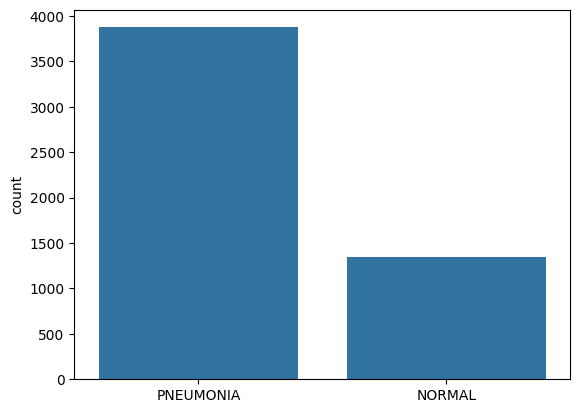

In [4]:
l=[]

for i in train :
    if(i[1]==0):
        l.append("PNEUMONIA")
    else:
        l.append("NORMAL")

sns.countplot(x=l)

In [ ]:
import random


x_train, y_train = [], []
x_test, y_test = [], []


for feature, label in train:
    x_train.append(feature)
    y_train.append(label)


for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

#ODEV KISMI
# Rastgele 1000 örnek seçtik
random_indices = random.sample(range(len(x_train)), 1000)

# Seçilen örnekleri test setine taşı
for idx in sorted(random_indices, reverse=True):  # Büyükten küçüğe silmek için sıraladık
    x_test.append(x_train.pop(idx)) # pop çıkardığı elemanı bir obj gibi tutar return eder o edilende text veriisnin içine yerleştirilir
    y_test.append(y_train.pop(idx))

print(len(x_train))  # Güncellenmiş eğitim veri seti uzunluğu
print(len(x_test))   # Güncellenmiş test veri seti uzunluğu


4216
1624


<Figure size 1000x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'PNEUMONIA')

<Axes: >

Text(0.5, 1.0, 'NORMAL')

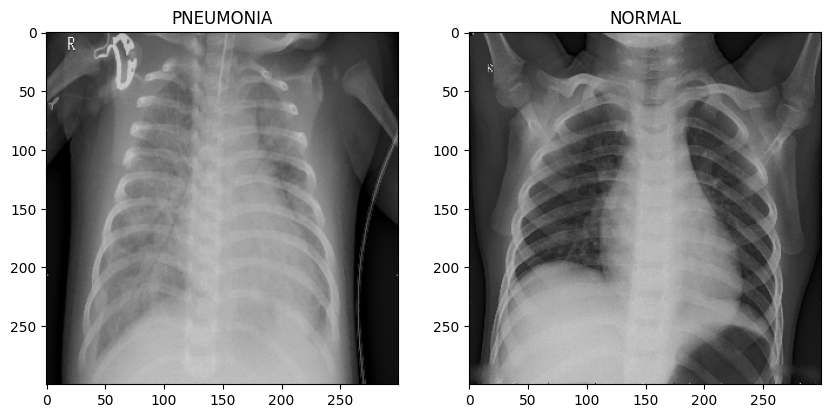

In [6]:
plt.figure(figsize=(10,5))                 # plt.figrue()
plt.subplot(1,2,1)                         # plt.subplot(1,2,1)
plt.imshow(train[0][0],cmap="gray")        # plt.imshow(x_train[0],cmap="gray")
plt.title(labels[train[0][1]])             # plt.title(labels[y_train[0]])

plt.subplot(1,2,2)
plt.imshow(train[-1][0],cmap="gray")
plt.title(labels[train[-1][1]])

In [6]:
#normalization
x_train=np.array(x_train)/255
x_test=np.array(x_test)/255

In [7]:
#(4216,150,150)  -> bu şekilde veremeyiz   (4216,150,150,1) şeklinde verebilriiz 

x_train=x_train.reshape(-1,img_size,img_size,1)
x_test=x_test.reshape(-1,img_size,img_size,1)

In [8]:
# list -> np.array
y_train=np.array(y_train)
y_test=np.array(y_test)

# Data Augmentation

In [9]:
# veri arttırma
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    featurewise_center=False , # veri setinin genel ortalamasını 0 yapar
    samplewise_center=False , # her bir örneğin ortalamasını 0 yapar
    featurewise_std_normalization=False , # veriyi verinin std bolme
    samplewise_std_normalization=False,# her bir örneğin kendi std sapmasına bolmesi
    zca_whitening=False, # zca beyazlatması yontemi daha hızlı ogrenmesi saplar korelasyonu azaltma0
    rotation_range=30 , # resimleri x derece reastgelere dondurur
    zoom_range=0.2 , # rastgele yakınlaştırma
    width_shift_range=0.1 ,# yatay olarak rastgele kaydırma
    height_shift_range=0.1 ,# dikey olarak rastgele kaydırma
    horizontal_flip=True , # resimleri rastgele yatay cevirir
    vertical_flip=True  # resimleri rastgele dikey cevirir
)

datagen.fit(x_train)



# Create Deep Learning model and train

In [10]:
"""
feature Extraction
conv2d -normalization -maxpooling
conv2d-dropout -normalization -maxpooling
conv2d -normalization -maxpooling
conv2d-dropout -normalization -maxpooling
conv2d-dropout -normalization -maxpooling

classification
flatten -dense-dropout-dense(output)
compiler:optimizer(rmsprop),loss(binary class ent.),metric(accuracy)
"""

#feature extraction
model=Sequential()
model.add(Conv2D(128,(7,7),strides=1,padding="same",activation="relu",input_shape=(180,180,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

model.add(Conv2D(64,(5,5),strides=1,padding="same",activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

model.add(Conv2D(32,(5,5),strides=1,padding="same",activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))


#classification - fully connected layer
model.add(Flatten())
model.add(Dense(units=128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=1,activation="sigmoid"))

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

'\nfeature Extraction\nconv2d -normalization -maxpooling\nconv2d-dropout -normalization -maxpooling\nconv2d -normalization -maxpooling\nconv2d-dropout -normalization -maxpooling\nconv2d-dropout -normalization -maxpooling\n\nclassification\nflatten -dense-dropout-dense(output)\ncompiler:optimizer(rmsprop),loss(binary class ent.),metric(accuracy)\n'

c:\Users\Harun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 128)  │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,166,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,433 (9.27 MB)

 Trainable params: 2,429,985 (9.27 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
learning_rate_reduction=ReduceLROnPlateau(monitor="val_accuracy",patience=2,verbose=1,factor=0.3,min_lr=0.0001)
epoch_number=5
history=model.fit(datagen.flow(x_train,y_train,batch_size=8),epochs=epoch_number,validation_data=datagen.flow(x_test,y_test),callbacks=[learning_rate_reduction])



In [12]:

print("loss of model :" , model.evaluate(x_test,y_test)[0])
print("Accuracy of model :" , model.evaluate(x_test,y_test)[1])

51/51 ━━━━━━━━━━━━━━━━━━━━ 29s 563ms/step - accuracy: 0.8606 - loss: 0.5752
loss of model : 0.5646497011184692
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 512ms/step - accuracy: 0.8606 - loss: 0.5752
Accuracy of model : 0.8448275923728943


# Evaluation

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epochs')

Text(0, 0.5, 'loss')

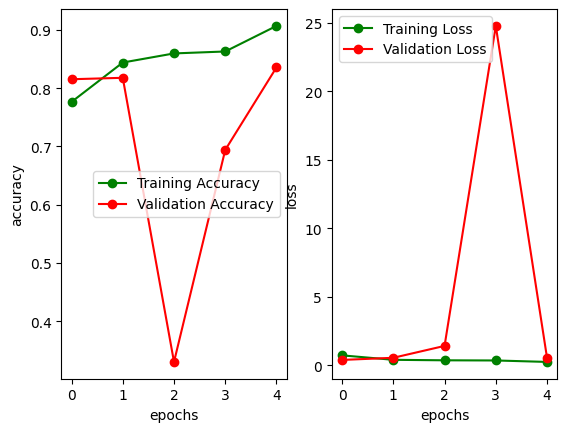

In [13]:
epochs=[i for i in range(epoch_number)]

fig,ax=plt.subplots(1,2)

train_acc=history.history["accuracy"]
train_loss=history.history["loss"]

val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

ax[0].plot(epochs,train_acc,"go-",label="Training Accuracy")
ax[0].plot(epochs,val_acc,"ro-",label="Validation Accuracy")
ax[0].legend()
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("accuracy")

ax[1].plot(epochs,train_loss,"go-",label="Training Loss")
ax[1].plot(epochs,val_loss,"ro-",label="Validation Loss")
ax[1].legend()
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")